We have a following optimization problem:
        $$y = argmin \frac{1}{2 \sigma}(||z - Ay ||_2^2) + \tau p(y), $$
where $$z = Ay + \sigma \varepsilon, $$ 

$z\in \mathbb{R}^N$, $z$ - observed image, $y$ - true image we are trying to find, $A$ - $N \times N$ blur matrix, $\varepsilon \sim N(0, I)$, $\sigma$ - standard deviation of noise, $\tau > 0$ - regalarization parameter, $p(y)$ - penalty. 

This functional is convex 

For all methods different kinds of penalty is used: 
- $p(y) = || y ||_1$
- $p(y) = || y ||_2$

Methods and techniques to use by team members:
- $Katya$ - cvxpy, lssqr, gurobi and other solvers
- $Nastya$ - gradiens descent, stochastic gradient
- $Dasha$ - proxi-gradient
- $Fedor$ - Newton and quasi-Newton.   

In [82]:
import numpy as np
import scipy.optimize
from scipy import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc
import pandas as pd
import sklearn.metrics
% matplotlib inline

In [83]:
def create_matrix(kernel, image_size): # creates
    k = kernel.shape[0]
    tmp = np.zeros(((image_size+k)**2, image_size))
    tmp1 = np.zeros(((image_size+k)**2))
    for i in range(k):
        tmp1[i*(image_size+k):i*(image_size+k) + k] += kernel[i]
    tmp[:,0] += tmp1
    for i in range(1, image_size):
        tmp[i:,i] += tmp1[:-i]
    #print(tmp.shape)
    tmp = tmp.T
    k = kernel.shape[0]
    final = sparse.csr_matrix(tmp)
    tmp = sparse.csr_matrix(tmp)
    for i in range(1, image_size):
        sparse_zeros = sparse.csr_matrix(np.zeros((image_size, (image_size+k)*i)))
        sparse_tmp = sparse.csr_matrix(sparse.hstack((sparse_zeros, tmp[:,:-(image_size+k)*i])))
        final = sparse.vstack((final, sparse_tmp))
    return final

def create_gaussian_kernel(bound, size):
    t = np.linspace(-bound, bound, size)
    bump = np.exp(-0.1*t**2)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    kernel = kernel/kernel.sum()
    return kernel

def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

def resize_img(img, pad_size):
    y = np.zeros((img.shape[0]+pad_size[0]+pad_size[1], img.shape[1]+pad_size[0]+pad_size[1], img.shape[2]-1))
    for i in range(img.shape[2]-1):
        y[:,:,i] = np.lib.pad(img[:,:,i], pad_size, padwithtens)
    return y.reshape(y.shape[0]**2, y.shape[2])

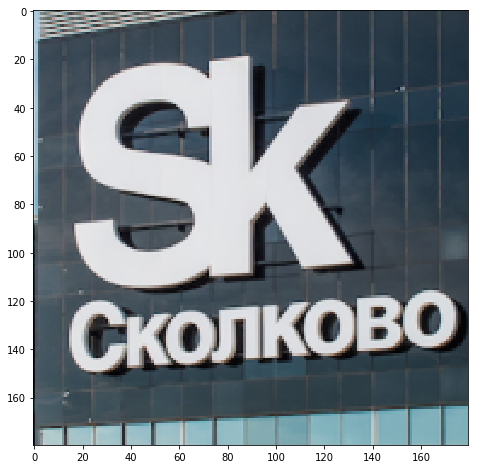

In [84]:
img = plt.imread('skolkovo.png')
plt.figure(figsize = (8, 8))
plt.imshow(img)

In [85]:
kernel = create_gaussian_kernel(4, 4)
k = kernel.shape[0]

pad = (k//2,k//2)

pad_img = resize_img(img, pad)
print(pad_img.shape)

(33856, 3)


In [86]:
A = create_matrix(kernel, img.shape[0])

new_img = A@pad_img
new_size = int(np.sqrt(new_img.shape[0]))
blurred_img = new_img.reshape((new_size, new_size, img.shape[2]-1))

Add noise after blurring.

In [87]:
sigma = 1e-3

In [88]:
blurred_with_noise = blurred_img + sigma*np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3)

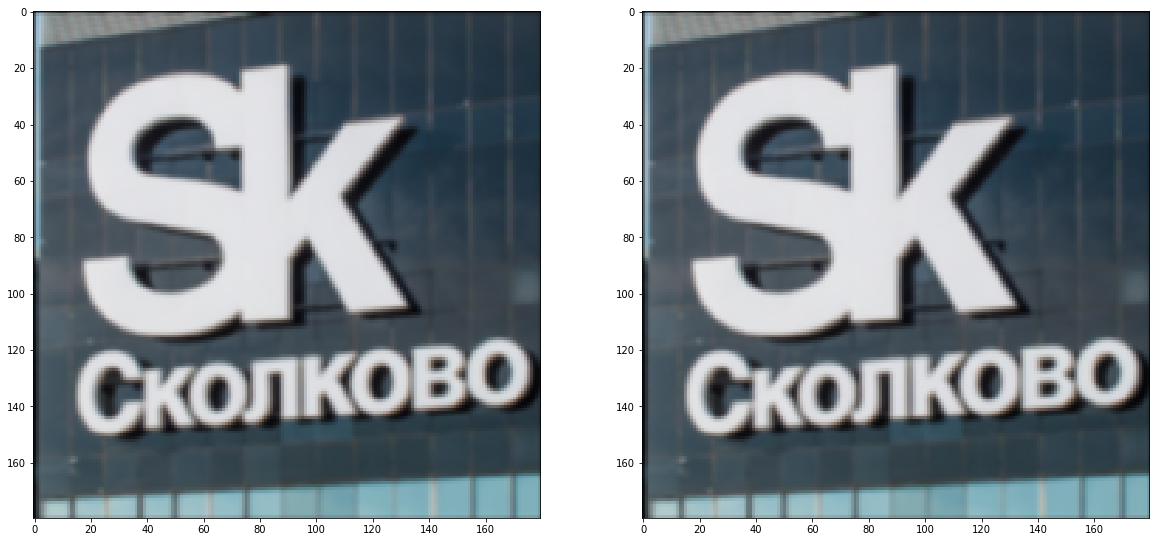

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(blurred_img)
ax[1].imshow(blurred_with_noise)

### Gradient descent

As we solve constrained problem we will use projected radient everywhere. Domain is n-dimension cubde $[0, 1]^n$. 

In [90]:
z = blurred_with_noise.reshape((blurred_with_noise.shape[0]**2, 3))

In [91]:
img = img[:, :, 0:3].reshape((blurred_with_noise.shape[0]**2, 3))

In [92]:
def loss(y, z, A, tau, pen):
    if pen == 'l1':
        return 1/(2*sigma)*((np.linalg.norm(z - A @ y))**2) + tau*np.linalg.norm(y, ord=1)
    if pen == 'l2':
        return 1/(2*sigma)*((np.linalg.norm(z - A @ y))**2) + tau*np.linalg.norm(y)

In [93]:
def gradient(y, z, A, tau, pen):
    I = np.ones(len(y))
    if pen == 'l1':
        return 1./sigma * A.T @ (A @ y - z) + tau * I
    if pen == 'l2':
        return 1./sigma * A.T @ (A @ y - z) + 2 * tau * y

In [94]:
def total_gradient(y, z, A, tau, pen):
    grad = np.zeros(y.shape)
    grad[:, 0] = gradient(y[:, 0], z[:, 0], A, tau, pen)
    grad[:, 1] = gradient(y[:, 1], z[:, 1], A, tau, pen)
    grad[:, 2] = gradient(y[:, 2], z[:, 2], A, tau, pen)
    return grad

In [95]:
def relative_error(y, init):
    a = np.linalg.norm(y[:, 0] - init[:, 0]) + np.linalg.norm(y[:, 1] - init[:, 1]) + np.linalg.norm(y[:, 2] - init[:, 2])
    b = np.linalg.norm(y[:, 2]) + np.linalg.norm(y[:, 1]) + np.linalg.norm(y[:, 0])
    return  a/b

In [96]:
num_iter = 250
y = np.zeros((A.shape[1], 3))
tau = 0.001
eps = 1e-3
alpha = 1e-3

In [97]:
def descent(y, z, A, tau, num_iter, eps, alpha, pen):
    res = []
    losses = []
    steps = []
    for i in tqdm(range(num_iter)):
        grad = total_gradient(y, z, A, tau, pen)
        y_i = y - alpha * grad
        y_i[y_i < 0] = 0
        y_i[y_i > 1] = 1
        res.append(abs(loss(y, z, A, tau, pen) - loss(y_i, z, A, tau, pen)))
        losses.append(loss(y_i, z, A, tau, pen))
        steps.append(y_i)
        if  res[i] > eps:
            y = y_i
        else:
            y = y_i
            break
    return y, res, losses, steps

In [98]:
y_l1, res_l1, loss_l1, steps_l1 = descent(y, z, A, tau, num_iter, eps, alpha, pen = 'l1')
y_l2, res_l2, loss_l2, steps_l2 = descent(y, z, A, tau, num_iter, eps, alpha, pen = 'l2')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 32.11it/s]


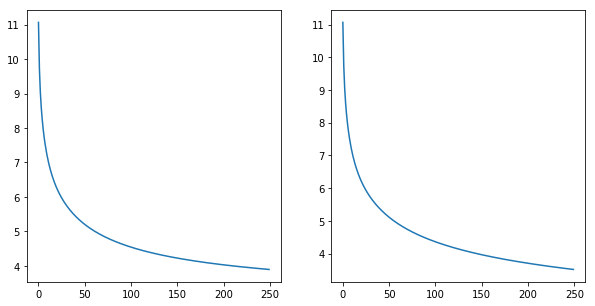

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(np.log(loss_l1))
ax[1].plot(np.log(loss_l2))

In [100]:
size = int(A.shape[1]**0.5)

result_l1 = y_l1.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
result_l2 = y_l2.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]

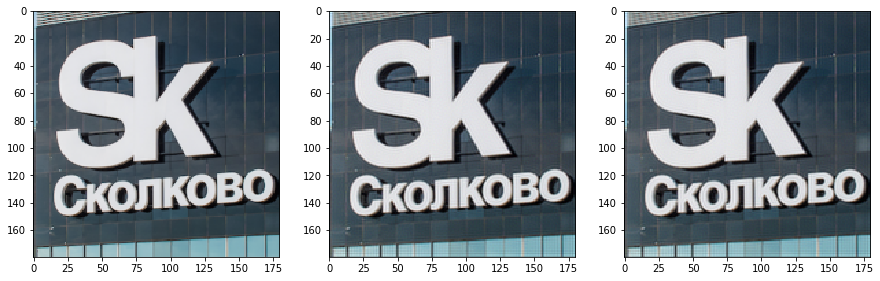

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(img.reshape((blurred_with_noise.shape[0], blurred_with_noise.shape[0], 3)))
ax[1].imshow(result_l1)
ax[2].imshow(result_l2)

In [102]:
print(relative_error(result_l1.reshape((result_l1.shape[0]**2, 3)), img))
print(relative_error(result_l2.reshape((result_l2.shape[0]**2, 3)), img))

0.0437650590967
0.0437686899266


In [103]:
print(loss_l1[-1])
print(loss_l2[-1]) 

49.2038621249
33.7509625438


In [104]:
rmse_l1 = []
for i in range(len(steps_l1)):
    result = steps_l1[i].reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
    result = result.reshape(result.shape[0]**2, 3)
    rmse_l1.append(sklearn.metrics.mean_squared_error(img, result))
    
rmse_l2 = []
for i in range(len(steps_l2)):
    result = steps_l2[i].reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
    result = result.reshape(result.shape[0]**2, 3)
    rmse_l2.append(sklearn.metrics.mean_squared_error(img, result))

We used fixed $\alpha$, which does not optimal in som sense. Lets try to use method of the fastest descent. 

### Fast descent

In this method we take $\alpha$ not constant, but at every $k$-th iteration we adapt $\alpha$ so that as loss decreased in the most significant way. 

In this case at every iteration we need to solve 1-D optimization task also. Lest use golden section for that.

In [105]:
num_iter = 250
y = np.zeros((A.shape[1], 3))
tau = 0.001
eps = 1e-3

In [106]:
def func(alpha, y, z, A, tau, grad, pen):
    y = y - alpha*grad
    y[y < 0] = 0
    y[y > 1] = 1
    return loss(y, z, A, tau, pen)

In [107]:
def fast_descent(y, z, A, tau, num_iter, eps, pen):
    res = []
    losses = []
    steps = []
    for i in tqdm(range(num_iter)):
        grad = total_gradient(y, z, A, tau, pen)
        alpha = scipy.optimize.minimize_scalar(func, args = (y, z, A, tau, grad, pen), method='golden').x
        y_i = y - alpha * grad
        y_i[y_i < 0] = 0
        y_i[y_i > 1] = 1
        res.append(abs(loss(y, z, A, tau, pen) - loss(y_i, z, A, tau, pen)))
        losses.append(loss(y_i, z, A, tau, pen))
        steps.append(y_i)
        if  res[i] > eps:
            y = y_i
        else:
            y = y_i
            break

    return y, res, losses, steps

In [108]:
y_l1_f, res_l1_f, loss_l1_f, steps_l1_f = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l1')
y_l2_f, res_l2_f, loss_l2_f, steps_l2_f = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l2')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:59<00:00,  4.20it/s]


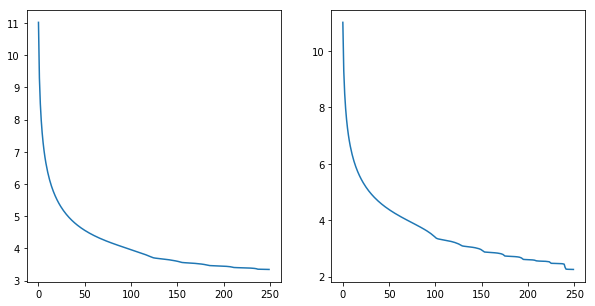

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.log(loss_l1_f))
ax[1].plot(np.log(loss_l2_f))

In [110]:
size = int(A.shape[1]**0.5)

result_l1_f = y_l1_f.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
result_l2_f = y_l2_f.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]

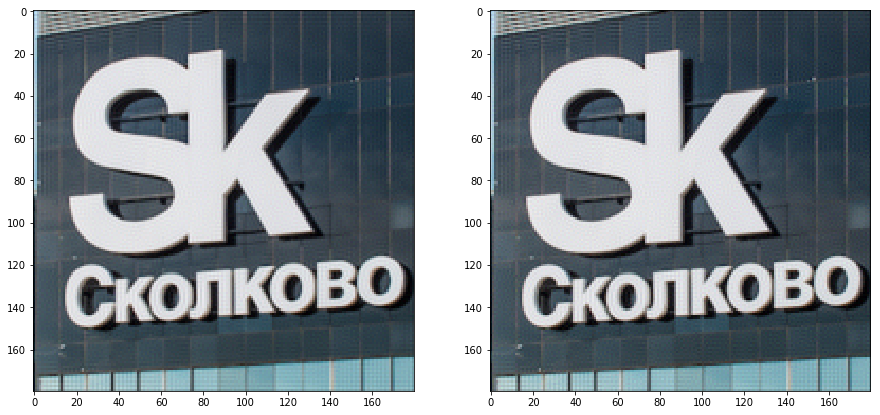

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(result_l1_f)
ax[1].imshow(result_l2_f)

In [112]:
print(relative_error(result_l1_f.reshape((result_l1_f.shape[0]**2, 3)), img))
print(relative_error(result_l2_f.reshape((result_l2_f.shape[0]**2, 3)), img))

0.0378314883583
0.0386451489419


In [113]:
rmse_l1_f = []
for i in range(len(steps_l1_f)):
    result = steps_l1_f[i].reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
    result = result.reshape(result.shape[0]**2, 3)
    rmse_l1_f.append(sklearn.metrics.mean_squared_error(img, result))
    rmse_l2_f = []

for i in range(len(steps_l2_f)):
    result = steps_l2_f[i].reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
    result = result.reshape(result.shape[0]**2, 3)
    rmse_l2_f.append(sklearn.metrics.mean_squared_error(img, result))

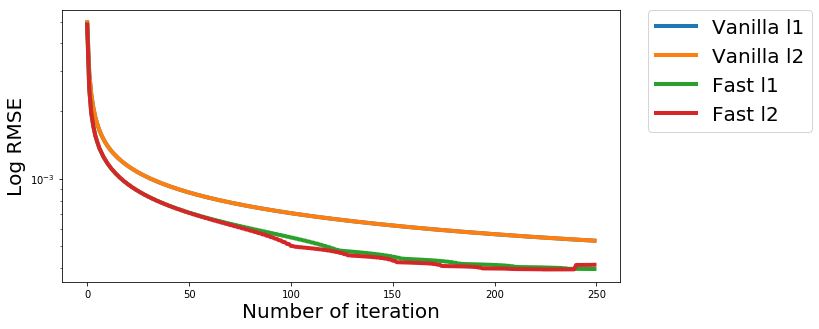

In [114]:
plt.figure(figsize=(10, 5))

plt.semilogy(rmse_l1, linewidth=4)
plt.semilogy(rmse_l2, linewidth=4)
plt.semilogy(rmse_l1_f, linewidth=4)
plt.semilogy(rmse_l2_f, linewidth=4)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log RMSE", fontsize=20)
plt.legend(['Vanilla l1', 'Vanilla l2', 'Fast l1', 'Fast l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [115]:
print(loss_l1_f[-1])
print(loss_l2_f[-1])

28.4862979093
9.53623760627


Relative error is smaller. Lets use fast descent with different initialization

### Random initialization

In [116]:
num_iter = 250
y = np.random.randn(A.shape[1], 3)

In [117]:
y_l1_rand, res_l1_rand, loss_l1_rand, steps_l1_rand = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l1')
y_l2_rand, res_l2_rand, loss_l2_rand, steps_l2_rand = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l2')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:02<00:00,  4.01it/s]


Text(0.5,1,'Restored image. l1 penalty function')

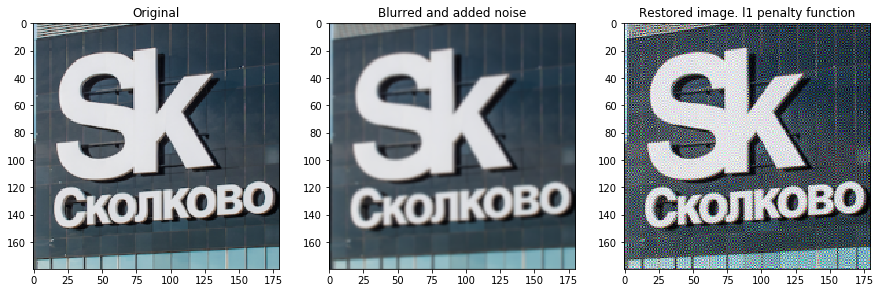

In [118]:
size = int(A.shape[1]**0.5)

result_l1_rand = y_l1_rand.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
result_l2_rand = y_l2_rand.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(img.reshape((blurred_with_noise.shape[0], blurred_with_noise.shape[0], 3)))
ax[0].set_title("Original")
ax[1].imshow(blurred_img)
ax[1].set_title("Blurred and added noise")
ax[2].imshow(result_l2_rand)
ax[2].set_title("Restored image. l1 penalty function")

In [119]:
print(relative_error(result_l1_rand.reshape((result_l1_rand.shape[0]**2, 3)), img))
print(relative_error(result_l2_rand.reshape((result_l2_rand.shape[0]**2, 3)), img))

0.228326068293
0.228996601093


Relative error is more than 5 times greater than with 1-s imitialization!

In [120]:
rmse_l1_rand = []
for i in range(len(steps_l1_rand)):
    rmse_l1_rand.append(sklearn.metrics.mean_squared_error(pad_img, steps_l1_rand[i]))
    
rmse_l2_rand = []
for i in range(len(steps_l2_rand)):
    rmse_l2_rand.append(sklearn.metrics.mean_squared_error(pad_img, steps_l2_rand[i]))

Text(0,0.5,'Log RMSE')

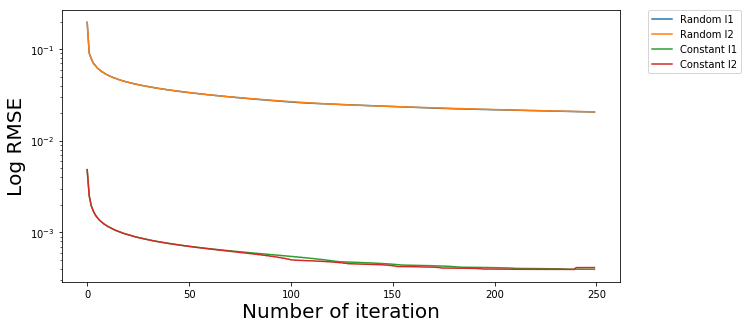

In [121]:
plt.figure(figsize=(10, 5))
plt.semilogy(rmse_l1_rand)
plt.semilogy(rmse_l2_rand)
plt.semilogy(rmse_l1_f)
plt.semilogy(rmse_l2_f)
plt.legend(['Random l1', 'Random l2', 'Constant l1', 'Constant l2'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log RMSE", fontsize=20)

Random initialisation is much worse than the constant one. 

### Initilization with blurred image

In [122]:
def resize_y(img, pad_size):
    y = np.zeros((img.shape[0]+pad_size[0]+pad_size[1], img.shape[1]+pad_size[0]+pad_size[1], img.shape[2]))
    for i in range(img.shape[2]):
        y[:,:,i] = np.lib.pad(img[:,:,i], pad_size, padwithtens)
    return y.reshape(y.shape[0]**2, y.shape[2])

In [123]:
y = resize_y(blurred_with_noise, pad)

In [124]:
num_iter = 500
tau = 0.001
eps = 1e-5

In [125]:
y_l1_blur, res_l1_blur, loss_l1_blur, steps_l1_blur = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l1')
y_l2_blur, res_l2_blur, loss_l2_blur, steps_l2_blur = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l2')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:55<00:00,  4.31it/s]


Text(0.5,1,'Restored image. l1 penalty function')

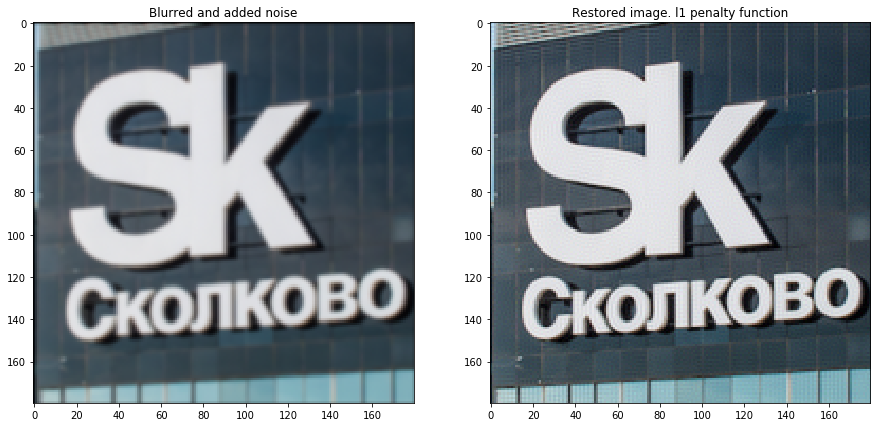

In [126]:
size = int(A.shape[1]**0.5)

result_l1_blur = y_l1_blur.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]
result_l2_blur = y_l2_blur.reshape((size, size, 3))[pad[0]:-pad[0], pad[0]:-pad[0]]

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(blurred_with_noise)
ax[0].set_title("Blurred and added noise")
ax[1].imshow(result_l1_blur)
ax[1].set_title("Restored image. l1 penalty function")

Text(0.5,1,'Restored image. l2 penalty function')

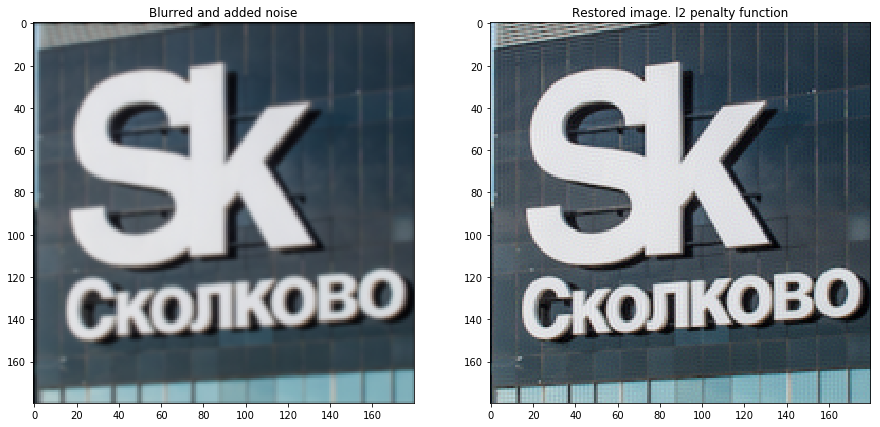

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(blurred_with_noise)
ax[0].set_title("Blurred and added noise")
ax[1].imshow(result_l2_blur)
ax[1].set_title("Restored image. l2 penalty function")

In [128]:
rmse_l1_blur = []
for i in range(len(steps_l1_blur)):
    rmse_l1_blur.append(sklearn.metrics.mean_squared_error(pad_img, steps_l1_blur[i]))
    
rmse_l2_blur = []
for i in range(len(steps_l2_blur)):
    rmse_l2_blur.append(sklearn.metrics.mean_squared_error(pad_img, steps_l2_blur[i]))

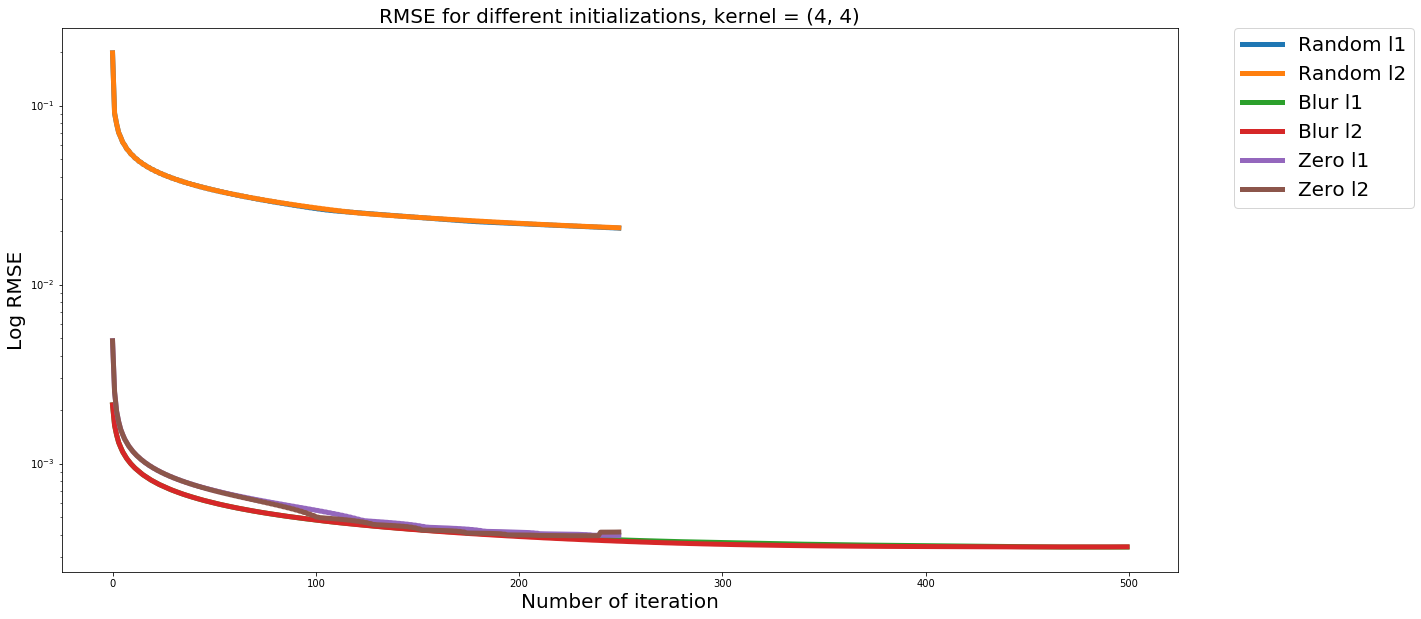

In [129]:
plt.figure(figsize=(20, 10))
plt.semilogy(rmse_l1_rand[:250], linewidth=5)
plt.semilogy(rmse_l2_rand[:250], linewidth=5)
plt.semilogy(rmse_l1_blur, linewidth=5)
plt.semilogy(rmse_l2_blur, linewidth=5)
plt.semilogy(rmse_l1_f, linewidth=5)
plt.semilogy(rmse_l2_f, linewidth=5)
plt.legend(['Random l1', 'Random l2', 'Blur l1', 'Blur l2', 'Zero l1', 'Zero l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("RMSE for different initializations, kernel = (4, 4)", fontsize=20)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log RMSE", fontsize=20)
plt.show()

It is a bit smaller than relative error of 0-s initialization. 

### Big kernel with optimal parameters

In [50]:
img = plt.imread('skolkovo.png')

In [51]:
img = plt.imread('skolkovo.png')

kernel = create_gaussian_kernel(3, 15)
k = kernel.shape[0]

pad = (k//2,k//2+1)

pad_img = resize_img(img, pad)

A = create_matrix(kernel, img.shape[0])

new_img = A@pad_img
new_size = int(np.sqrt(new_img.shape[0]))
blurred_img = new_img.reshape((new_size, new_size, img.shape[2]-1))

In [52]:
blurred_with_noise_big = blurred_img + sigma*np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3)

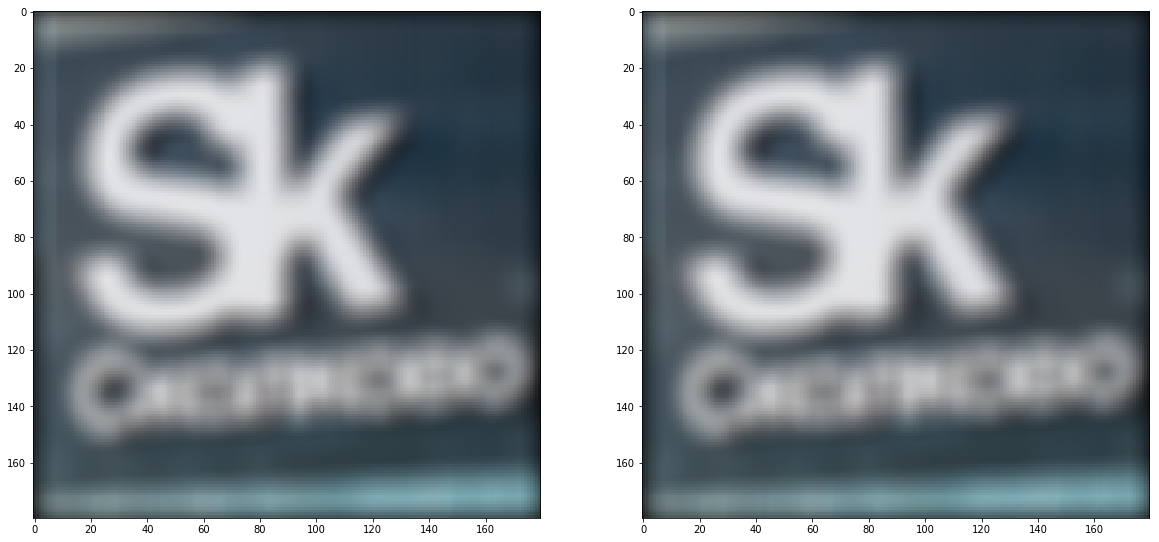

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(blurred_img)
ax[1].imshow(blurred_with_noise_big)

In [54]:
y = resize_y(blurred_with_noise_big, pad)

In [55]:
num_iter = 250
tau = 0.001
eps = 1

In [56]:
y_l1_big, res_l1_big, loss_l1_big, steps_l1_big = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l1')
y_l2_big, res_l2_big, loss_l2_big, steps_l2_big = fast_descent(y, z, A, tau, num_iter, eps, pen = 'l2')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [09:45<00:00,  2.34s/it]


Text(0.5,1,'Restored image. l1 penalty function')

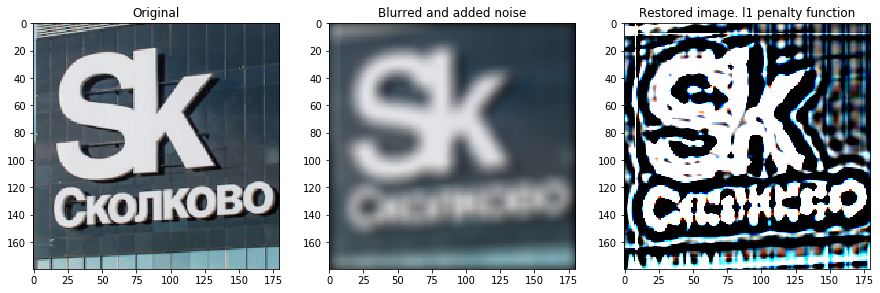

In [57]:
size = int(A.shape[1]**0.5)
result_l1_big = y_l1_big.reshape((size, size, 3))[pad[0]:-pad[1], pad[0]:-pad[1]]

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(blurred_with_noise_big)
ax[1].set_title("Blurred and added noise")
ax[2].imshow(result_l1_big)
ax[2].set_title("Restored image. l1 penalty function")

Text(0.5,1,'Restored image. l1 penalty function')

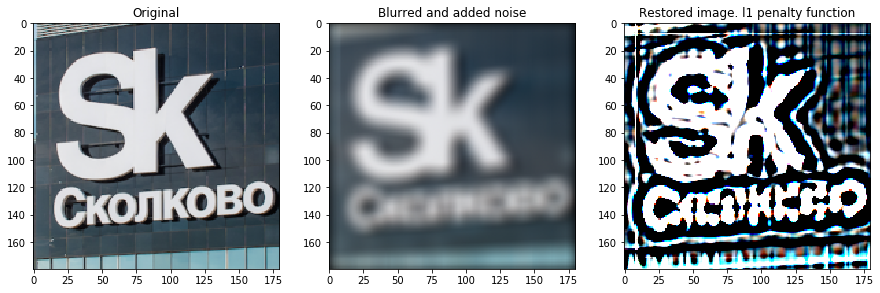

In [58]:
size = int(A.shape[1]**0.5)
result_l2_big = y_l2_big.reshape((size, size, 3))[pad[0]:-pad[1], pad[0]:-pad[1]]

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(blurred_with_noise_big)
ax[1].set_title("Blurred and added noise")
ax[2].imshow(result_l2_big)
ax[2].set_title("Restored image. l1 penalty function")

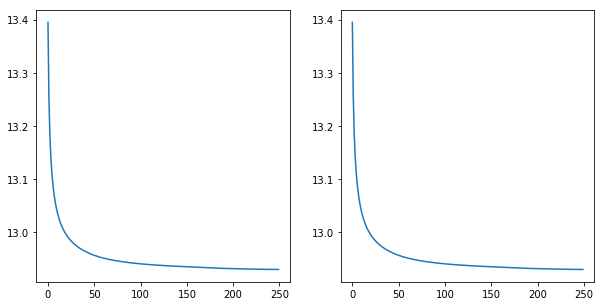

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.log(loss_l1_big))
ax[1].plot(np.log(loss_l2_big))

In [60]:
rmse_l1_big = []
for i in range(len(steps_l1_big)):
    rmse_l1_big.append(sklearn.metrics.mean_squared_error(pad_img, steps_l1_big[i]))
    
rmse_l2_big = []
for i in range(len(steps_l2_big)):
    rmse_l2_big.append(sklearn.metrics.mean_squared_error(pad_img, steps_l2_big[i]))

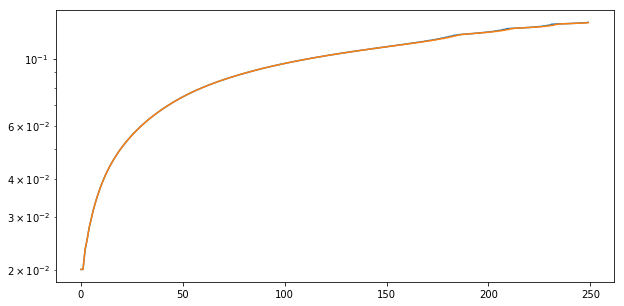

In [61]:
plt.figure(figsize=(10, 5))
plt.semilogy(rmse_l1_big)
plt.semilogy(rmse_l2_big)

In [62]:
img = img[:, :, 0:3].reshape((blurred_with_noise.shape[0]**2, 3))

In [63]:
print(relative_error(result_l1_big.reshape((result_l1_rand.shape[0]**2, 3)), img))
print(relative_error(result_l2_big.reshape((result_l2_rand.shape[0]**2, 3)), img))

0.545999030304
0.545585845144


### Summary of different results

In [64]:
new_rmse_l1_small = pd.read_csv('RMSE1_l1.csv', header=None)
new_rmse_l2_small = pd.read_csv('RMSE1_l2.csv', header=None)
new_rmse_l1_big = pd.read_csv('RMSE2_l1.csv', header=None)
new_rmse_l2_big = pd.read_csv('RMSE2_l2.csv', header=None)

In [65]:
new_loss_l1_small = pd.read_csv('Loss1_l1.csv', header=None)
new_loss_l2_small = pd.read_csv('Loss1_l2.csv', header=None)
new_loss_l1_big = pd.read_csv('Loss2_l1.csv', header=None)
new_loss_l2_big = pd.read_csv('Loss2_l2.csv', header=None)

In [66]:
rmse_l2_big[-1]

0.13153575466821818

In [67]:
prox_rmse = pd.read_csv('rmse.csv', header=None)
prox_loss = pd.read_csv('loss.csv', header=None) 

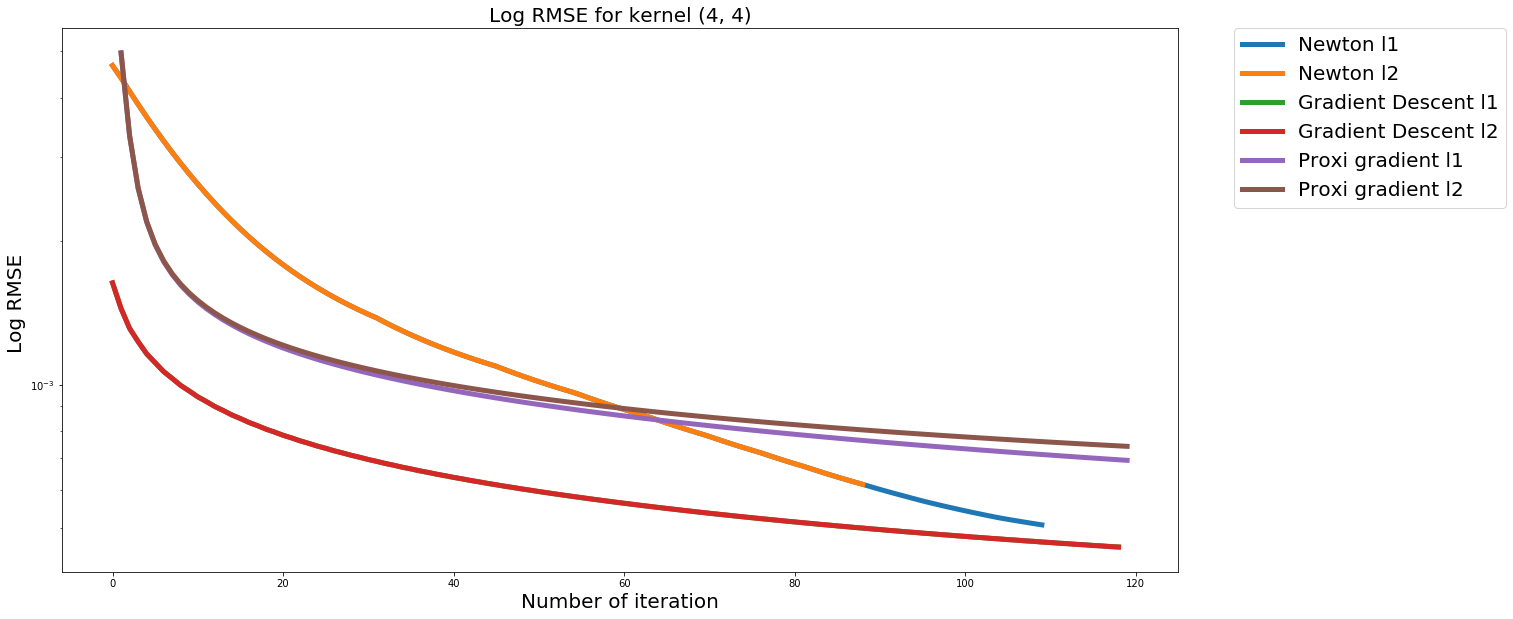

In [72]:
plt.figure(figsize=(20, 10))
plt.semilogy(new_rmse_l1_small[0], linewidth=5)
plt.semilogy(new_rmse_l2_small[0], linewidth=5)
plt.semilogy(rmse_l1_blur[1:120], linewidth=5)
plt.semilogy(rmse_l2_blur[1:120], linewidth=5)
plt.semilogy(prox_rmse[2][1:120], linewidth=5)
plt.semilogy(prox_rmse[3][1:120], linewidth=5)
plt.title("Log RMSE for kernel (4, 4)", fontsize=20)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log RMSE ", fontsize=20)
plt.legend(['Newton l1', 'Newton l2', 'Gradient Descent l1', 'Gradient Descent l2', 'Proxi gradient l1', 'Proxi gradient l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

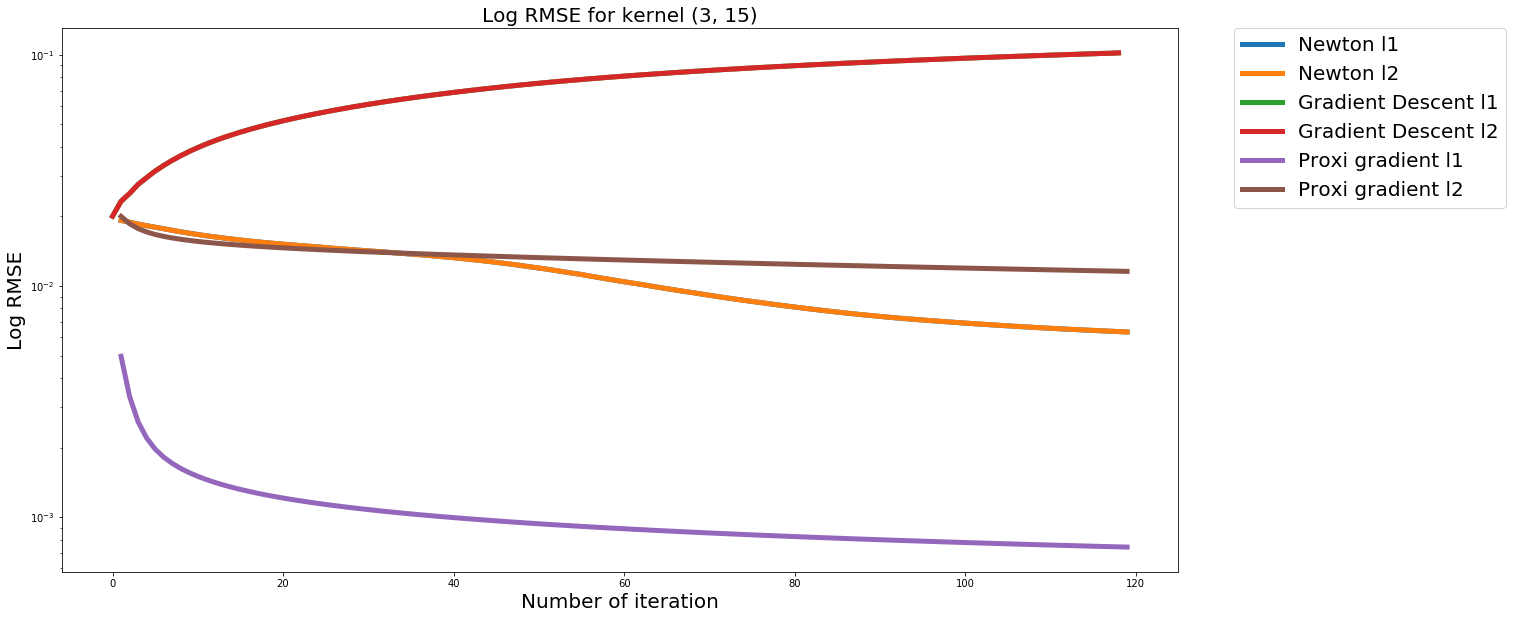

In [74]:
plt.figure(figsize=(20, 10))
plt.semilogy(new_rmse_l1_big[0][1:120], linewidth=5)
plt.semilogy(new_rmse_l2_big[0][1:120], linewidth=5)
plt.semilogy(rmse_l1_big[1:120], linewidth=5)
plt.semilogy(rmse_l2_big[1:120], linewidth=5)
plt.semilogy(prox_rmse[3][1:120], linewidth=5)
plt.semilogy(prox_rmse[4][1:120], linewidth=5)
plt.title("Log RMSE for kernel (3, 15)", fontsize=20)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log RMSE", fontsize=20)
plt.legend(['Newton l1', 'Newton l2', 'Gradient Descent l1', 'Gradient Descent l2', 'Proxi gradient l1', 'Proxi gradient l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

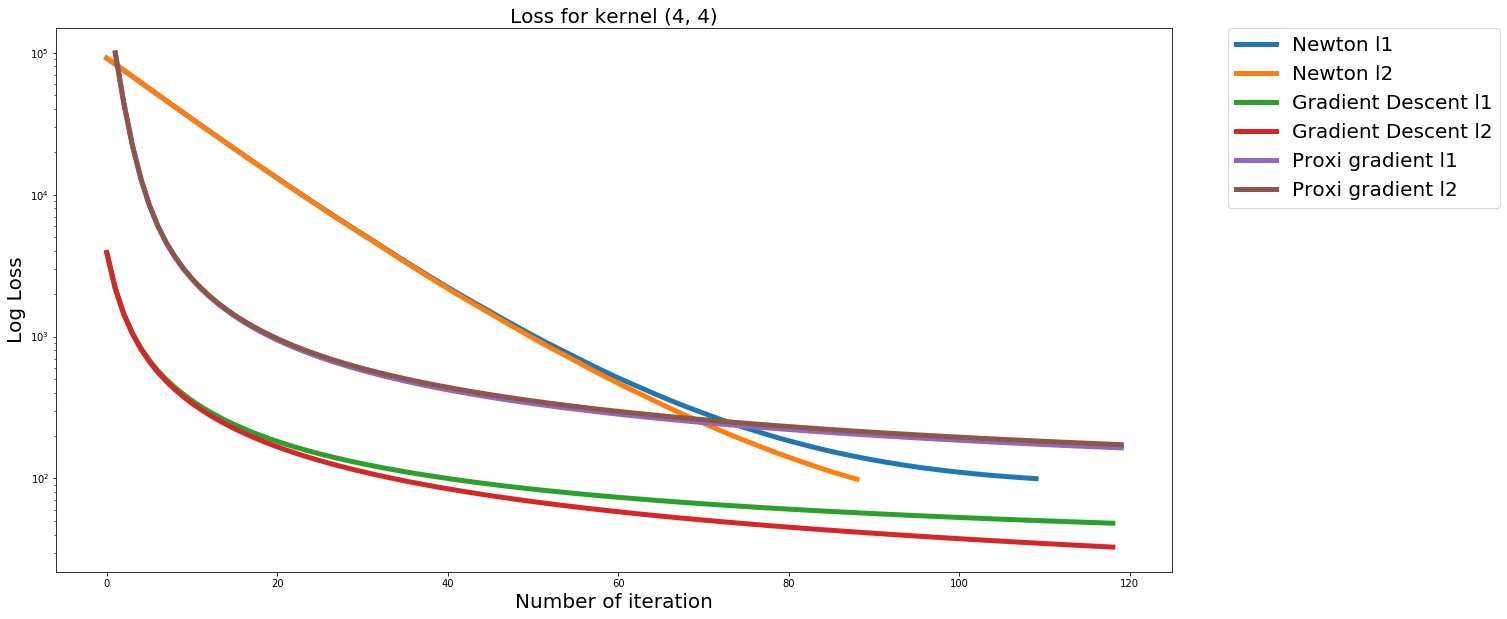

In [75]:
plt.figure(figsize=(20, 10))
plt.semilogy(new_loss_l1_small[0], linewidth=5)
plt.semilogy(new_loss_l2_small[0], linewidth=5)
plt.semilogy(loss_l1_blur[1:120], linewidth=5)
plt.semilogy(loss_l2_blur[1:120], linewidth=5)
plt.semilogy(prox_loss[2][1:120], linewidth=5)
plt.semilogy(prox_loss[3][1:120], linewidth=5)
plt.title("Loss for kernel (4, 4)", fontsize=20)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log Loss", fontsize=20)
plt.legend(['Newton l1', 'Newton l2', 'Gradient Descent l1', 'Gradient Descent l2', 'Proxi gradient l1', 'Proxi gradient l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

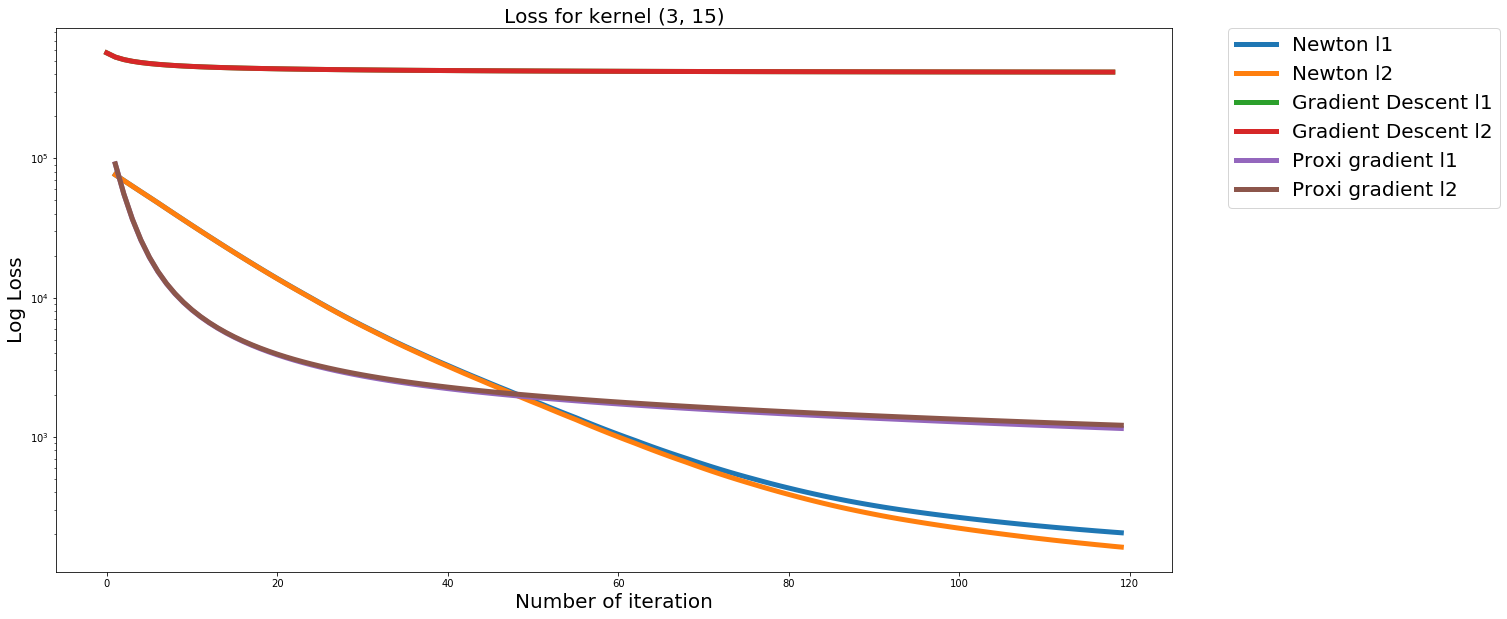

In [76]:
plt.figure(figsize=(20, 10))
plt.semilogy(new_loss_l1_big[0][1:120], linewidth=5)
plt.semilogy(new_loss_l2_big[0][1:120], linewidth=5)
plt.semilogy(loss_l1_big[1:120], linewidth=5)
plt.semilogy(loss_l2_big[1:120], linewidth=5)
plt.semilogy(prox_loss[4][1:120], linewidth=5)
plt.semilogy(prox_loss[5][1:120], linewidth=5)
plt.title("Loss for kernel (3, 15)", fontsize=20)
plt.xlabel("Number of iteration", fontsize=20)
plt.ylabel("Log Loss", fontsize=20)
plt.legend(['Newton l1', 'Newton l2', 'Gradient Descent l1', 'Gradient Descent l2', 'Proxi gradient l1', 'Proxi gradient l2'], fontsize=20, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()